In [ ]:
# Inference and Reasoning with Bayesian Networks

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 2 (due: Monday, 16 May, 23:59)

Name: Suraj Narayanan Sasikumar

Student ID: 5881495

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 20|
|Weight|20% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 5%. No assignments shall be accepted if it is later than 10 days. | 
| Coorperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |

This assignment has two parts. In the first part, you reason using basic rules of probability to estimate the probability and likelihood of different events (maximum 7 marks). In the second part, you implement two different approaches to perform inference on a given Bayesian Network (maximum 13 marks). All formulas and calculations which are not part of Python code should be written using $\LaTeX$.

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$

Setting up the environment

In [200]:
import matplotlib.pyplot as plt
from itertools import repeat
import numpy as np
import pandas as pd
import time
import sys

%install_ext https://sml.forge.nicta.com.au/isml16/tutorial/tikzmagic.py

Installed tikzmagic.py. To use it, type:
  %load_ext tikzmagic


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


In [33]:
%load_ext tikzmagic
%matplotlib inline

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


## Part 1: Reasoning and Sampling with Graphical Models

### Problem setting

We are interested to predict the outcome of the election in an imaginary country, called Under Some Assumptions (USA). There are four candidates for whom the citizens can **Vote** for: Bernie, Donald, Hillary, and Ted. The citizens live in four **Region**s: north, south, east and west. We have general demographic information about the people, namely: **Gender** (male, female) and **Hand**edness (right, left). Based on surveys done by an external company, we believe that the **Region** and **Gender** affects whether the people use their **Jacket**s full time, part time or never. Surprisingly, the company told us that the **Age** of their shoes (new, worn, old) depends on how often they wear their **Jacket**s. Furthermore, the **Gender** and their preferred **Hand** affects the **Colour** of their hat (white, black). Finally, surveys say that the citizens will **Vote** based on their **Region**, **Age** of their shoes and **Colour** of their hats.

###  (1 mark) Draw the graphical model

Based on this information, write the directed graphical model using tikz. Note that tikz code has to be in its own code cell.


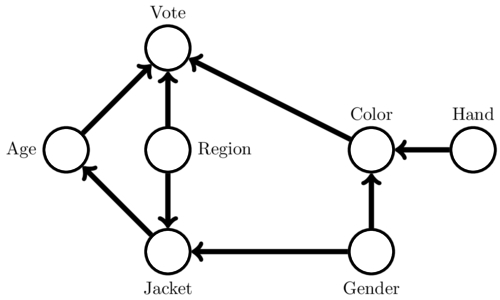

In [34]:
%%tikz --scale 2 --size 500,300 -f jpg
\tikzstyle{vertex}=[circle, draw=black, fill=white, line width=0.5mm, minimum size=25pt, inner sep=0pt]
\tikzstyle{edge} = [draw, line width=1mm, ->]

\node[vertex,label=left:{Age}] (a) at (0,0) {};
\node[vertex,label=above:{Vote}] (v) at (1,1) {};
\node[vertex,label=above:{Color}] (c) at (3,0) {};
\node[vertex,label=right:{Region}] (r) at (1,0) {};
\node[vertex,label=below:{Jacket}] (j) at (1,-1) {};
\node[vertex,label=below:{Gender}] (g) at (3,-1) {};
\node[vertex,label=above:{Hand}] (h) at (4,0) {};

\foreach \source/ \dest in {a/v, r/v, c/v, r/j, j/a, g/j, g/c, h/c}
        \path[edge] (\source) -- (\dest);

### Conditional probability tables

After paying the survey firm some more money, they provided the following conditional probability tables.

|$p(R)$ | R=n | R=s | R=e | R=w |
|:-----:|:--:|:--:|:--:|:--:|
|marginal| 0.2 | 0.1 | 0.5 | 0.2 |

|$p(G)$ | G=m | G=f |
|:-----:|:--:|:--:|
|marginal| 0.3 | 0.7 |

|$p(H)$ | H=r | H=l |
|:-----:|:--:|:--:|
|marginal| 0.9 | 0.1 |

| $p(J|R,G)$ | R=n,G=m | R=n,G=f | R=s,G=m | R=s,G=f | R=e,G=m | R=e,G=f | R=w,G=m | R=w,G=f |
|:-----:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|**J**=full $\quad$  |0.9 |0.8 |0.1 | 0.3 |0.4 |0.01| 0.02 | 0.2  |
|**J**=part $\quad$  |0.08|0.17|0.03| 0.35|0.05|0.01| 0.2  | 0.08 |
|**J**=never $\quad$ |0.02|0.03|0.87| 0.35|0.55|0.98| 0.78 | 0.72 |

| $p(A|J)$ | J=full | J=part | J=never |
|:-----:|:--:|:--:|:--:|
|**A**=new  |0.01|0.96|0.3|
|**A**=worn |0.98|0.03|0.5|
|**A**=old  |0.01|0.01|0.2|

| $p(C|G,H)$ | G=m,H=r | G=m,H=l | G=f,H=r | G=f,H=l |
|:-----:|:--:|:--:|:--:|:--:|
|**C**=black $\quad$ |0.9 |0.83 |0.17 | 0.3 |
|**C**=white $\quad$ |0.1 |0.17|0.83 | 0.7 |

The final conditional probability table is given by the matrix below. The order of the rows are alphabetical, and the order of the columns are also given below.

*Hint: The given column name format may not be the best way to code it.*

In [35]:
column_names = ['north,new,black', 'north,new,white', 'north,worn,black', 'north,worn,white', 
                'north,old,black', 'north,old,white', 'south,new,black', 'south,new,white', 
                'south,worn,black', 'south,worn,white', 'south,old,black', 'south,old,white', 
                'east,new,black', 'east,new,white', 'east,worn,black', 'east,worn,white', 
                'east,old,black', 'east,old,white', 'west,new,black', 'west,new,white', 
                'west,worn,black', 'west,worn,white', 'west,old,black', 'west,old,white']

VcRAC_vals = np.array([
        [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
        [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
        [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
        [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
    ])


### (1 mark) Encode the 7 distributions

Encode the 7 conditional probability tables in python using ```pandas.Series``` and ```pandas.DataFrame```.

Estimate the joint distribution of **Jacket**, **Region** and **Gender**. What is the the probability of full time **Jacket** usage among women in the west?

In [188]:
def __getDFrame(col_names, index_list, col_values):
    """
        Encode Data as Pandas DataFrame with MultiIndex Support
    """
    df = pd.DataFrame(col_values,
         index=pd.MultiIndex.from_tuples(list(zip(*index_list))),
         columns=col_names)
    return df

def encodeData():
    R_col_names = ['P']
    R_index_list = [['north', 'south', 'east', 'west']]
    R_col_values = [0.2, 0.1, 0.5, 0.2]
    R = __getDFrame(R_col_names, R_index_list, R_col_values)

    G_col_names = ['P']
    G_index_list = [['male', 'female']]
    G_col_values = [0.3, 0.7]
    G = __getDFrame(G_col_names, G_index_list, G_col_values)

    H_col_names = ['P']
    H_index_list = [['right', 'left']]
    H_col_values = [0.9, 0.1]
    H = __getDFrame(H_col_names, H_index_list, H_col_values)

    def __dup_lst_elem(lst, times):
        return [x for item in lst for x in repeat(item, times)]

    JcRG_col_names = ['P']
    J_index_list = ['full', 'part', 'never']
    JcRG_index_list = [ __dup_lst_elem(R_index_list[0], 6),
                        __dup_lst_elem(G_index_list[0], 3)*4,
                        J_index_list*24 ]
    JcRG_col_values = [ 0.9, 0.08, 0.02, 0.8, 0.17, 0.03, 0.1, 0.03, 0.87, 0.3,
                        0.35, 0.35, 0.4, 0.05, 0.55, 0.01, 0.01, 0.98, 0.02,
                        0.2, 0.78, 0.2, 0.08, 0.72 ]
    JcRG = __getDFrame(JcRG_col_names, JcRG_index_list, JcRG_col_values)


    AcJ_col_names = ['P']
    A_index_list = ['new', 'worn', 'old']
    AcJ_index_list = [ __dup_lst_elem(J_index_list, 3),
                       A_index_list*9 ]
    AcJ_col_values = [ 0.01, 0.98, 0.01, 0.96, 0.03, 0.01, 0.3, 0.5, 0.2 ]
    AcJ = __getDFrame(AcJ_col_names, AcJ_index_list, AcJ_col_values)


    CcGH_col_names = ['P']
    C_index_list = ['black', 'white']
    CcGH_index_list = [ __dup_lst_elem(G_index_list[0], 4),
                        __dup_lst_elem(H_index_list[0], 2)*2,
                        C_index_list*8 ]
    CcGH_col_values = [ 0.9, 0.1, 0.83, 0.17, 0.17, 0.83, 0.3, 0.7 ]
    CcGH = __getDFrame(CcGH_col_names, CcGH_index_list, CcGH_col_values)

    column_names = ['north,new,black', 'north,new,white', 'north,worn,black', 'north,worn,white',
                    'north,old,black', 'north,old,white', 'south,new,black', 'south,new,white',
                    'south,worn,black', 'south,worn,white', 'south,old,black', 'south,old,white',
                    'east,new,black', 'east,new,white', 'east,worn,black', 'east,worn,white',
                    'east,old,black', 'east,old,white', 'west,new,black', 'west,new,white',
                    'west,worn,black', 'west,worn,white', 'west,old,black', 'west,old,white']

    VcRAC_col_values = np.array([
            [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
            [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
            [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
            [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
        ]).flatten('F')

    VcRAC_col_names = ['P']
    V_index_list = ['Bernie', 'Donald', 'Hillary', 'Ted']
    VcRAC_index_list = [ __dup_lst_elem(R_index_list[0], 24),
                        __dup_lst_elem(A_index_list, 8)*4,
                        __dup_lst_elem(C_index_list, 4)*12,
                        V_index_list*96 ]
    VcRAC_col_values = np.array([
            [0.1,0.1,0.4,0.02,0.2,0.1,0.1,0.04,0.2,0.1,0.1 ,0.1,0.4 ,0.1 ,0.1,0.1 ,0.1,0.04,0.3,0.2,0.1,0.3,0.34,0.35],
            [0.3,0.4,0.2,0.5 ,0.1,0.2,0.1,0.5 ,0.1,0.2,0.5 ,0.3,0.2 ,0.42,0.2,0.67,0.4,0.4 ,0.1,0.1,0.5,0.1,0.1 ,0.1],
            [0.5,0.4,0.3,0.3 ,0.5,0.6,0.6,0.3 ,0.5,0.4,0.36,0.3,0.28,0.3 ,0.4,0.1 ,0.4,0.16,0.4,0.2,0.3,0.3,0.4 ,0.5],
            [0.1,0.1,0.1,0.18,0.2,0.1,0.2,0.16,0.2,0.3,0.04,0.3,0.12,0.18,0.3,0.13,0.1,0.4 ,0.2,0.5,0.1,0.3,0.16,0.05]
        ]).flatten('F')
    VcRAC = __getDFrame(VcRAC_col_names, VcRAC_index_list, VcRAC_col_values)
    
    JcRG.sort_index(inplace=True)
    AcJ.sort_index(inplace=True)
    CcGH.sort_index(inplace=True)
    VcRAC.sort_index(inplace=True)

    return (R, G, H, JcRG, AcJ, CcGH, VcRAC)

R, G, H, JcRG, AcJ, CcGH, VcRAC = encodeData()

### (3 marks) Naive sampling approach

Implement the following sampling scheme:
1. Order the nodes in the following fashion, R, G, H, J, A, C, V. Work through each node in order.
2. For the first node R, draw a sample from p(R).
3. For each subsequent node, draw a sample from the conditional distribution $p(X \,|\, parents(X))$ where $parents(X)$ are the parents of the variable $X$ in the graphical model.

Your code should be modular, with appropriate use of (well documented) functions.

In [190]:
BN = {
    'R':None,
    'G':None,
    'H':None,
    'J':['R', 'G'],
    'A':['J'],
    'C':['G', 'H'],
    'V':['R','A','C']
}

def get_sample():
    sample = {}
    for name, df in zip(['R', 'G', 'H', 'J', 'A', 'C', 'V'],[R, G, H, JcRG, AcJ, CcGH, VcRAC]):
        if BN[name]:
            sampled_values = []
            for pa in BN[name]:
                sampled_values.append(sample[pa])
            df_slice = df['P'][tuple(sampled_values)]
            df_idx = list(df_slice.index)
            sample[name] = np.random.choice(df_idx, p=df_slice)            
        else:
            sample[name] = np.random.choice(df.index, p=df['P'])
    return sample

get_sample()

{'A': 'worn',
 'C': 'black',
 'G': 'female',
 'H': 'left',
 'J': 'full',
 'R': 'west',
 'V': 'Donald'}

The sampler provides a sample from the joint distribution of all random variables. Why was the order in point 1. chosen? Are there other possible orders which achieve the same sampler? If yes, specify another one.

### Solution

The order was chosen so that the random variables appearing later in the order does not have any children in the graphical model. The reasoning behind this is that samples must be drawn from dependent random variables first before the random variables that are conditioned on them can be samples. This ordering ensures that at each step all of the parent values would have been instantiated.

Yes, there are other possible orders as un-conditioned random variables can be samples in any order, and conditioned random variables can be evaluated given the set of random variables it is conditioned on is already samples from.
Examples:
$$
    H \rightarrow R \rightarrow G \rightarrow J \rightarrow A \rightarrow C \rightarrow V \\
    R \rightarrow G \rightarrow H \rightarrow C \rightarrow J \rightarrow A \rightarrow V
$$

Write a small test case to check that your sampler is doing the right thing by using it to verify the sum rule and product rule of probability. You can do so by drawing many samples from both sides of each rule, and show that the proportion of each state is as expected.

In [201]:
def draw_n_samples(n):
    return [get_sample() for _ in range(n)]

print("Drawing 10,000 samples...")
sys.stdout.flush()
start = time.clock()
poll_samples = pd.DataFrame(draw_n_samples(1 * 10**4))
stop  = time.clock() - start
print ('Sampling rate: ', len(poll_samples)/stop, "samples/sec")    

Drawing 10,000 samples...
Sampling rate:  583.2416477463073 samples/sec


#### Sum Rule and Product Rule

$$
\begin{align}
P(G) &= \sum_{H} P(G,H) \tag{Sum Rule}\\
P(G,H) &= P(G|H)P(H) \tag{Product Rule}
\end{align}
$$

In [241]:
def __G_H_Joint(poll_samples):
    total_sample_cnt = len(poll_samples)
    P_G_H = [len(poll_samples[(poll_samples['G']=='male')   & (poll_samples['H']=='right')].index)/total_sample_cnt, 
             len(poll_samples[(poll_samples['G']=='female') & (poll_samples['H']=='right')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['G']=='male')   & (poll_samples['H']=='left')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['G']=='female') & (poll_samples['H']=='left')].index)/total_sample_cnt ]
    return P_G_H

def sum_rule_LHS(poll_samples):
    total_sample_cnt = len(poll_samples)
    P_G = [len(poll_samples[poll_samples['G']=='male'].index)/total_sample_cnt, 
           len(poll_samples[poll_samples['G']=='female'].index)/total_sample_cnt]
    return P_G

def sum_rule_RHS(poll_samples):
    total_sample_cnt = len(poll_samples)    
    P_G_H = __G_H_Joint(poll_samples)
    SUM_H__P_G_H = [P_G_H[0] + P_G_H[2], P_G_H[1] + P_G_H[3]]
    return SUM_H__P_G_H

def prod_rule_LHS(poll_samples):
    return __G_H_Joint(poll_samples)

def prod_rule_RHS(poll_samples):
    total_sample_cnt = len(poll_samples)
    H_r_sample = poll_samples[poll_samples['H']=='right']
    H_l_sample = poll_samples[poll_samples['H']=='left']

    P_H = [len(H_r_sample.index)/total_sample_cnt, 
           len(H_l_sample.index)/total_sample_cnt]

    P_GcH = [(len(H_r_sample[H_r_sample['G']=='male'].index)/len(H_r_sample)),
             (len(H_r_sample[H_r_sample['G']=='female'].index)/len(H_r_sample)),
             (len(H_l_sample[H_l_sample['G']=='male'].index)/len(H_l_sample)),
             (len(H_l_sample[H_l_sample['G']=='female'].index)/len(H_l_sample))]
    
    P_G_H = [P_GcH[0]*P_H[0], P_GcH[1]*P_H[0], P_GcH[2]*P_H[1], P_GcH[3]*P_H[1]]
    return P_G_H

print("Sum Rule")
print("LHS P(G)[male, female]:", sum_rule_LHS(poll_samples))
print("RHS SUM_H(P(G,H))     :", sum_rule_RHS(poll_samples))

print("\nProduct Rule")
print("LHS P(G,H)[(m,r), (f,r), (m,l), (f,l)]:", prod_rule_LHS(poll_samples))
print("RHS P(G|H)P(H)                        :", prod_rule_RHS(poll_samples))

Sum Rule
LHS P(G)[male, female]: [0.2967, 0.7033]
RHS SUM_H(P(G,H))     : [0.29669999999999996, 0.7033]

Product Rule
LHS P(G,H)[(m,r), (f,r), (m,l), (f,l)]: [0.2643, 0.6343, 0.0324, 0.069]
RHS P(G|H)P(H)                        : [0.2643, 0.6343, 0.032400000000000005, 0.069]


### (2 marks) Estimating conditional probabilities

Use your sampler above to estimate:
1. the marginal probability of $p(V)$,
2. the probability of women that vote for Hillary, $p(V=Hillary \,|\, G=female)$.

Show a plot that describes the number of samples that are needed to estimate $p(V)$ accurately.

Marginal Probability P(V)[Bernie, Donald, Hilary, Ted]: [0.1553, 0.3412, 0.2969, 0.2066]
Probability of women voters for Hilary: p(V=Hillary|G=female): 0.2728565334849993
Achieved accuracy of 99.9% consistently after 834 number of samples


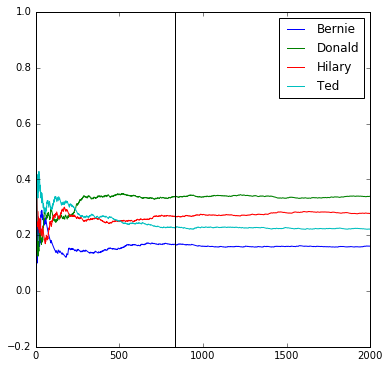

In [313]:
def P_V(poll_samples):
    total_sample_cnt = len(poll_samples)
    P_V = [len(poll_samples[(poll_samples['V']=='Bernie')].index)/total_sample_cnt, 
             len(poll_samples[(poll_samples['V']=='Donald')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['V']=='Hillary')].index)/total_sample_cnt,
             len(poll_samples[(poll_samples['V']=='Ted')].index)/total_sample_cnt ]
    return P_V

def P_VcG_for_value(poll_samples, candidate, gender):
    total_sample_cnt = len(poll_samples)
    G_given_sample = poll_samples[poll_samples['G']==gender]  
    P_VcG_value = (len(G_given_sample[G_given_sample['V']==candidate].index)/len(G_given_sample))
    return P_VcG_value

def get_sample_stream(poll_samples, sub_sample_size, cons = 50, acc=1e-03):
    sample_stream = []
    accuracy_sample_size = 0
    consistency_cnt = 0
    found = False
    for i in range(1,sub_sample_size):
        sample_stream.append(P_V(poll_samples[:i]))
        if i>10 and not found:
            steam_diff = np.diff(sample_stream, axis=0)[-1]
            if all(np.isclose([0,0,0,0], steam_diff, atol=acc)):
                consistency_cnt += 1
                if consistency_cnt>cons:
                    accuracy_sample_size = i
                    found = True
    return (sample_stream, accuracy_sample_size)

def plot_sample_stabilization(sample_size,y, accuracy_sample_size):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    p = ax.plot(range(1,sample_size), y)
    ax.axvline(accuracy_sample_size, color='k')
    ax.legend(p, ('Bernie', 'Donald', 'Hilary', 'Ted'), loc='upper right')
    ax.set_ylim([-0.2,1])
    ax.set_xlim([1,sample_size])

#Make Under Some Assumptions Great Aagain!
print("Marginal Probability P(V)[Bernie, Donald, Hilary, Ted]:", P_V(poll_samples))
print("Probability of women voters for Hilary: p(V=Hillary|G=female):", 
      P_VcG_for_value(poll_samples, 'Hillary', 'female'))
    
sub_sample_size = 2000
sample_stream, accuracy_sample_size = get_sample_stream(poll_samples, sub_sample_size, 100, 1e-03)
print("Achieved accuracy of 99.9% consistently after", accuracy_sample_size, "number of samples")
plot_sample_stabilization(sub_sample_size, sample_stream, accuracy_sample_size)

### (3 marks) Direct estimation of conditional probabilities

Write down the expression of the joint probability $p(R,G,H,J,A,C,V)$ in terms of the conditional probabilities in the graphical model.

Use the sum rule and product rule of probability to derive:
* $p(V = Donald \;\,|\, G = male)$
* $p(G = male \,|\, V = Donald)$
* the marginal probability of **Vote**s.

### Solution

Using the encoding of the conditional probability tables in ```pandas.Series``` and ```pandas.DataFrame```, and your expressions above, calculate the desired conditional probability tables. Your code should be modular, with appropriate use of (well documented) functions.

Report the tables above in markdown.

### Solution

### (3 marks) Estimating structure

It turns out that the external company that we used to estimate the probabilities above did not do such a good job. There is reason to believe that the given graphical model above is wrong. However, it is believed that the true graphical model has more or less the same number of edges, and is sharing some conditional probability tables. In particular, assume that the conditional probability table for **Voting** conditioned on **Region**, **Age** and **Colour** remains the same. 

An enterprising student from the Amazing Neighbourhood University (ANU) obtained some data by polling. This data is available from [this website](https://sml.forge.nicta.com.au/isml16/assignments/poll-data.csv.gz). Use this data to identify a good graphical model.

Show:
1. The tikz image of the graphical model (this has to be in its own cell)
2. The conditional probability tables as markdown

Argue why the new graphical model that you estimated from the data is a good one.

*A majority of marks are allocated for the method of finding the graphical model.*

In [ ]:
# Solution

### Solution

## Part 2: Analysis of algorithms

### (4 marks) Incremental EM
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Btheta}{\boldsymbol{\mathsf{\theta}}}$
$\newcommand{\Cond}{\,|\,}$

Given are $N$ independent data points $\B{x}_1,\dots,\B{x}_N$ and a Gaussian mixture model with corresponding latent variables $\B{z}_1,\dots,\B{z}_N$. As the joint distribution $p(\B{X}, \B{Z} \Cond \Btheta)$ factorises over the data points, one can develop an incremental form of EM in which only one data point is processed in each E- and M-step if the mixture component is a member of the exponential family. 

Consider a mixture of Gaussians. The update for the effective number of data points $N_k$ after having seen data point $\B{x}_m$ can be derived as
$$
  N_k^\text{new} = N_k^\text{old} + \gamma^\text{new}(z_{mk}) - \gamma^\text{old}(z_{mk})
$$

1. Define $\gamma^\text{new}(z_{mk})$.
- Prove the above given result for the update of $N_k$.
- Develop the update formulas for the other parameters of the Gaussian mixture model: 
  - mixture coefficients $\mathsf{\pi}_k$, 
  - means $\mathsf{\mu}_k$, and 
  - covariances $\mathsf{\Sigma}_k$.
- Define and explain two properties of this incremental EM algorithm which make it preferable method over batch EM.

### Solution

### (3 marks) Sampling from a piecewise exponential distribution

In the lecture we mentioned sampling from the *exponential distribution*
given by
$$
  p(y) = \lambda e^{-\lambda y}.
$$

The *piecewise exponential distribution* is defined as
$$
  p(z) = k_m \lambda_m e^{-\lambda_m (z - z_{m-1})} 
         \qquad \qquad  
         \widehat{z}_{m-1,m} < z \le \widehat{z}_{m,m+1}
$$
where $ \widehat{z}_{m-1, m} $ is the point of intersection of the tangent 
lines at $ z_{m-1} $ and $ z_m $,
$ \lambda_m $ is the slope of the tangent at $ z_m $ and 
$ k_m $ accounts for the corresponding offset.

(a) Using the result for sampling from a single distribution,
devise an algorithm for sampling from the piecewise 
distribution.

(b) Given a desired distribution $ p(z) $, describe precisely how the 
piecewise exponential distribution can be used to sample from this
distribution.

(c) Explain how one can use rejected samples to better 
approximate the desired distribution $ p(z) $.



### Solution